In [1]:
import tidy3d as td
import numpy as np
from scipy.sparse.linalg import gmres


from matplotlib import pyplot as plt
import seaborn as sns
import time

## Problem setup

In [32]:
# Physical parameters
L = 1
C0 = 1e17 * 1e-12 # um^-3
T0 = 300 # K
vt0 = td.K_B * T0 # V
mu0 = 1500 * 1e8 # um2/(Vs)
Er = 5 # relative permittivity
Vmax = 2 # V
t0 = L*L/Vmax/mu0 # seconds

mu_n = 1500 * 1e8 / mu0
mu_p = 500 * 1e8 / mu0
tau_n = tau_p = 1e-8 / t0
Eg = 1.12 / Vmax # non-dimenal energy bandgap

ni = 1e10 * 1e-12 / C0

# Numerical parameters
N = 50 # NUmber of "grid" nodes
dx = L / (N - 1) / L # dimensionless grid spacing

T = 300 * np.ones(N) / T0

vt0_bar = vt0 / Vmax

eps0 = td.EPSILON_0 * vt0 / (td.Q_e * C0 * L * L)
eps0 = td.EPSILON_0 * Vmax / (td.Q_e * C0 * L * L)
print(f"eps0 {eps0:0.3e}")

R0 = mu0 * Vmax * C0 / L / L
print(f"R0 {R0:0.3e} 1/(um³s)")
print(f"t0 {t0:0.3e}")
print(f"dx {dx:0.3e}$")
print(f"Vmax {Vmax:0.3e} V; Vt0 {vt0:0.3e} V, vt0_bar {vt0_bar:0.3e}")

eps0 1.105e-03
R0 3.000e+16 1/(um³s)
t0 3.333e-12
dx 2.041e-02$
Vmax 2.000e+00 V; Vt0 2.585e-02 V, vt0_bar 1.293e-02


## Bernoulli function

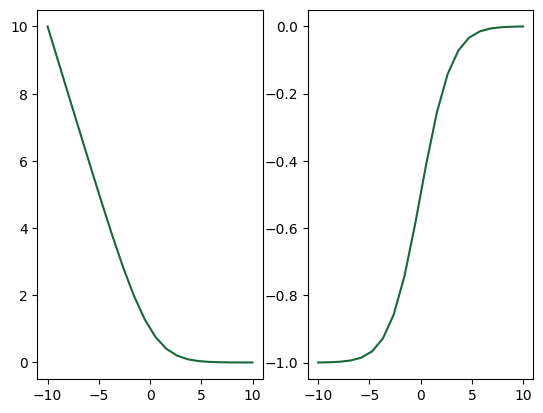

In [3]:
def B(x):
    if np.isclose(x, 0.0):
        return 1
    else:
        return x/(np.exp(x) - 1)

def dB(x):
    if np.isclose(x, 0.0):
        return 0.5
    else:
        return (np.exp(x)*(1-x) - 1)/(np.exp(x) - 1)/(np.exp(x) - 1)

_, ax = plt.subplots(1, 2)
ax[0].plot(np.linspace(-10,10,20), [B(x) for x in np.linspace(-10,10,20)])
ax[1].plot(np.linspace(-10,10,20), [dB(x) for x in np.linspace(-10,10,20)])
plt.show()

## Build matrix

In [4]:
def plus_minus_indeces(i):
    ip1 = i + 1
    im1 = i - 1
    if i == N - 1:
        ip1 = 0
        # since I'm including both ends in the 
        ip1 = 1
    if i == 0:
        im1 = N - 1
        im1 = N - 2
    return ip1, im1

def compute_jacobian(J, U, T, is_log = False, modified_jac = False, forcing = False):
    # reset jacobian 
    J.fill(0)

    phi = U[0:N]
    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]
    
    # fill in Gauss equation terms
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        J[i,im1] = - eps0 * Er / dx
        J[i,i] = 2 * eps0 * Er / dx
        J[i,ip1] = - eps0 * Er / dx
    
    # fill in conservation eqs.
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        F_n1_2 = -(phi[i] - phi[im1]) / dx + vt0_bar * (T[i] - T[im1]) / dx
        F_1_2  = -(phi[ip1] - phi[i]) / dx + vt0_bar * (T[ip1] - T[i]) / dx

        Fp_n1_2 = -(phi[i] - phi[im1]) / dx - vt0_bar * (T[i] - T[im1]) / dx
        Fp_1_2  = -(phi[ip1] - phi[i]) / dx - vt0_bar * (T[ip1] - T[i]) / dx

        if forcing:
            F_n1_2 = forcing
            F_1_2 = forcing
            Fp_n1_2 = forcing
            Fp_1_2 = forcing
        
        T_n1_2 = 0.5 * (T[im1] + T[i])
        T_1_2 = 0.5 * (T[ip1] + T[i])

        du_im1 = du_i = du_ip1 = 1
        if is_log and not modified_jac:
            du_im1 = n[im1]
            du_i = n[i]
            du_ip1 = n[ip1]
        
        # n terms
        J[N+i, N+im1] += -mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar) * du_im1
        J[N+i, N+i] += mu_n * vt0_bar /dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar)) * du_i
        J[N+i, N+ip1] += -mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar) * du_ip1

        # print(1/(mu_n * vt0_bar * T_n1_2/dx) * np.array([J[N+i, N+im1], J[N+i, N+i], J[N+i, N+ip1]]), J[N+i, N+im1] + J[N+i, N+i] + J[N+i, N+ip1])

        if is_log:
            du_im1 = p[im1]
            du_i = p[i]
            du_ip1 = p[ip1]

        # p terms
        J[2*N+i, 2*N+im1] += - mu_p * vt0_bar * T_n1_2/dx * B(-Fp_n1_2 * dx / T_n1_2 / vt0_bar) * du_im1
        J[2*N+i, 2*N+i] += mu_p * vt0_bar /dx * (T_1_2 * B(-Fp_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(Fp_n1_2 * dx / T_n1_2 / vt0_bar)) * du_i
        J[2*N+i, 2*N+ip1] += - mu_p * vt0_bar * T_1_2/dx * B(Fp_1_2 * dx / T_1_2 / vt0_bar) * du_ip1
    return J

def source_term(S, U, is_log = False):
    S.fill(0)

    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]
    
    for i in range(N):
        S[i] = dx * (p[i] - n[i] - np.sin(2*np.pi*dx*i))

        # recombination terms
        R = C0/t0 / R0 * (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))
        S[N + i] = - dx * R
        S[2*N + i] = - dx * R
    return S

def compute_source_jacobian(Js, U, is_log = False, modified_jac = False):
    Js.fill(0)

    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]

    for i in range(N):
        Js[i, N + i] = - dx
        Js[i, 2*N + i] = dx

        d = tau_n*(n[i] + ni) + tau_p*(p[i] + ni)

        dn = dp = 1
        if is_log and not modified_jac:
            dn = n[i]
            dp = p[i]

        Js[N + i, N + i] = -dx * C0/t0/R0 * (p[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_n) * dn
        Js[N + i, 2*N + i] = -dx * C0/t0/R0 * (n[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_p) * dp

        Js[2*N + i, N + i] = -dx * C0/t0/R0 * (p[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_n) * dn
        Js[2*N + i, 2*N + i] = -dx * C0/t0/R0 * (n[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_p) * dp
    return Js

## Non-linear J(U)

In [5]:
def compute_jacobian_u(Res, U, T, is_log = False):
    # reset jacobian 

    phi = U[0:N]
    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]
    
    # fill in Gauss equation terms
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)

        Res[i] += eps0 * Er / dx * (phi[im1] - 2 * phi[i] + phi[ip1])
        
        F_n1_2 = -(phi[i] - phi[im1]) / dx + vt0_bar * (T[i] - T[im1]) / dx
        F_1_2  = -(phi[ip1] - phi[i]) / dx + vt0_bar * (T[ip1] - T[i]) / dx

        Fp_n1_2 = -(phi[i] - phi[im1]) / dx - vt0_bar * (T[i] - T[im1]) / dx
        Fp_1_2  = -(phi[ip1] - phi[i]) / dx - vt0_bar * (T[ip1] - T[i]) / dx
        
        T_n1_2 = 0.5 * (T[im1] + T[i])
        T_1_2 = 0.5 * (T[ip1] + T[i])

        Res[N + i] += mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar) * n[im1]
        Res[N + i] += -mu_n * vt0_bar /dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar)) * n[i]
        Res[N + i] += mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar) * n[ip1]

        # p terms
        Res[2*N + i] += mu_p * vt0_bar * T_n1_2/dx * B(-Fp_n1_2 * dx / T_n1_2 / vt0_bar) * p[im1]
        Res[2*N + i] += -mu_p * vt0_bar /dx * (T_1_2 * B(-Fp_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(Fp_n1_2 * dx / T_n1_2 / vt0_bar)) * p[i]
        Res[2*N + i] += mu_p * vt0_bar * T_1_2/dx * B(Fp_1_2 * dx / T_1_2 / vt0_bar) * p[ip1]
    return Res

## Matrices with AD

In [6]:
def flux_function(U, T, i):
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    # Fluxes for node i
    ip1, im1 = plus_minus_indeces(i)
        
    F_n1_2 = -(phi[i] - phi[im1]) / dx
    F_1_2  = -(phi[ip1] - phi[i]) / dx
    
    T_n1_2 = 0.5 * (T[im1] + T[i])
    T_1_2 = 0.5 * (T[ip1] + T[i])

    # flux Gauss
    flux_phi = - eps0 * Er / dx * (phi[ip1] - 2 * phi[i] + phi[im1])

    # flux n
    flux_n = -mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar) * n[im1]
    flux_n += mu_n * vt0_bar/dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar)) * n[i]
    flux_n += -mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar) * n[ip1]

    # flux p
    flux_p = - mu_p * vt0_bar * T_n1_2/dx * B(-F_n1_2 * dx / T_n1_2 / vt0_bar) * p[im1]
    flux_p += mu_p * vt0_bar/dx * (T_1_2 * B(-F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(F_n1_2 * dx / T_n1_2 / vt0_bar)) * p[i]
    flux_p += - mu_p * vt0_bar * T_1_2/dx * B(F_1_2 * dx / T_1_2 / vt0_bar) * p[ip1]

    return [flux_phi, flux_n, flux_p]

def compute_jacobian_ad(J, U, T):
    J.fill(0)

    delta = 1e-3

    for i in range(N):
        for j in range(3*N):
            Up = U.copy()
            Um = U.copy()
            Up[j] = Up[j] + delta
            Um[j] = Um[j] - delta
            [fp_phi, fp_n, fp_p] = flux_function(Up, T, i)
            [fm_phi, fm_n, fm_p] = flux_function(Um, T, i)
            
            J[i, j] = (fp_phi - fm_phi) / (2 * delta)
            
            dFn_dU = (fp_n - fm_n) / (2 * delta)
            dFp_dU = (fp_p - fm_p) / (2 * delta)
            if np.abs(dFn_dU) > 1000:
                dFn_dU = 1000 * dFn_dU / np.abs(dFn_dU)
            if np.abs(dFp_dU) > 100:
                dFp_dU = 1000 * dFp_dU / np.abs(dFp_dU)
            
            J[N + i, j] = dFn_dU
            J[2*N + i, j] = dFp_dU
            # print(i, f"{fp_n:0.5e}, {fp_p:0.5e}, {fm_n:0.5e}, {fm_p:0.5e}. {J[N + i, j]:0.5e}, {J[2*N + i, j]:0.5e}")
    return J

def compute_source_jacobian_ad(Js, U):
    Js.fill(0)
    Sp = np.zeros(3*N)
    Sm = np.zeros(3*N)

    delta = 1e-5

    for i in range(N):
        for j in range(3*N):
            Up = U.copy()
            Um = U.copy()
            Up[j] = Up[j] + delta
            Um[j] = Um[j] - delta
            Sp = source_term(Sp, Up)
            Sm = source_term(Sm, Um)
            
            Js[i, j] = (Sp[i] - Sm[i]) / (2 * delta)
            Js[N + i, j] = (Sp[N + i] - Sm[N + i]) / (2 * delta)
            Js[2*N + i, j] = (Sp[2*N + i] - Sm[2*N + i]) / (2 * delta)
    return Js

## Initial solution

In [7]:
U = np.ones(3*N)

def init_solution(U, is_log = False):
    U.fill(0)
    for i in range(N):
        c = np.sin(2*np.pi*dx*i)

        log_ni = ni
        if is_log:
            log_ni = np.log(ni)

        U[N + i] = log_ni
        U[2*N + i] = log_ni
        
        if c > 0:
            U[2*N + i] = ni + 0.8*c
            if is_log:
                U[2*N + i] = np.log(ni + 0.8*c)
        elif c < 0:
            U[N + i] = ni - 0.8 * c
            if is_log:
                U[N + i] = np.log(ni - 0.8 * c)
    return U
    
U = init_solution(U)

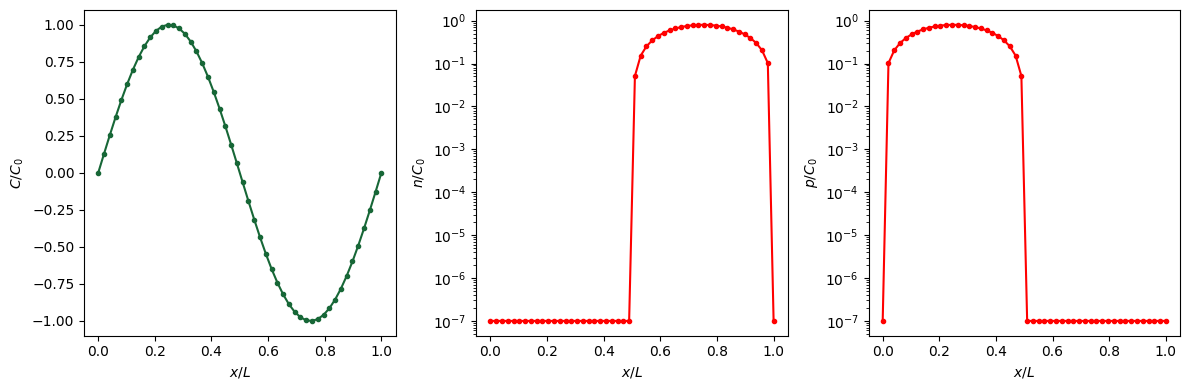

In [8]:
# Show doping and initial solution
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(np.linspace(0, 1, N), np.sin(2*np.pi*np.linspace(0, 1, N)), '.-')
ax[0].set_ylabel("$C/C_0$")

ax[1].semilogy(np.linspace(0, 1, N), U[N:2*N], 'r.-')
ax[1].set_ylabel("$n/C_0$")

ax[2].semilogy(np.linspace(0, 1, N), U[2*N:3*N], 'r.-')
ax[2].set_ylabel("$p/C_0$")

for i in range(3):
    ax[i].set_xlabel("$x/L$")
plt.tight_layout()
plt.show()

## Plot Jacobians

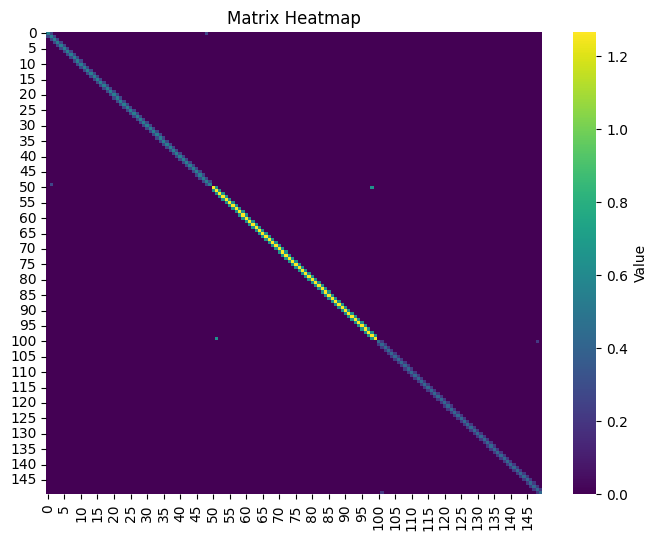

In [9]:
J = np.zeros([3*N,3*N])
J = compute_jacobian(J, U, T)

# Jad = np.zeros([3*N,3*N])
# Jad = compute_jacobian_ad(Jad, U, T)

# diff_jac = np.abs(J - Jad)

Js = np.zeros([3*N,3*N])
Js = compute_source_jacobian(Js, U)

# Plot heatmap
plt.figure(figsize=(8, 6))
# sns.heatmap(np.abs(J), annot=False, cmap='viridis', cbar_kws={'label': 'Value'}, vmin=0, vmax=100)
sns.heatmap(np.abs(J), annot=False, cmap='viridis', cbar_kws={'label': 'Value'}, vmin=0)
# sns.heatmap(Jad, annot=False, cmap='viridis', cbar_kws={'label': 'Value'})
plt.title("Matrix Heatmap")
plt.show()

In [10]:
# estimate jacobian terms
# psi
print(eps0*Er/dx)

# n
print(mu_n*T[0]*vt0_bar/dx, mu_n*Vmax/L)

# p
print(mu_p*T[0]*vt0_bar/dx, mu_p*Vmax/L)


0.27079111854481014
0.6333739947570001 2.0
0.211124664919 0.6666666666666666


In [11]:
# visualize solution
def plot_solution(U, T, is_log = False):
    phi = U[0:N]
    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]
        
    _, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].plot(np.linspace(0,1,N), phi, 'k.-')
    ax[0].set_ylabel("$\psi/V$")
    
    ax[1].semilogy(np.linspace(0,1,N), n, 'r.-')
    ax[1].set_ylabel("$n/C_0$")
    
    ax[2].semilogy(np.linspace(0,1,N), p, 'b.-')
    ax[2].set_ylabel("$p/C_0$")
    
    ax[3].plot(np.linspace(0,1,N), T, 'c.-')
    ax[3].set_ylabel("$T/T_0$")

    for i in range(4):
        ax[i].set_xlabel("$x/L$")
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Solve with Jacobi method

In [12]:
def calc_rhs(S, J, U):
    return S - np.dot(J, U)
    
def updated_sol(U, dU, is_log = False):
    if is_log:
        du_max = 10
        for i in range(N):
            if dU[N+i] > du_max:
                dU[N+i] = du_max
            if dU[2*N+i] > du_max:
                dU[2*N+i] = du_max
            
            # max negative value
            max_neg = -30
            if U[N+i] + dU[N+i] < max_neg:
                U[N+i] = max_neg
            else:
                U[N+i] += dU[N+i]
            if U[2*N+i] + dU[2*N+i] < max_neg:
                U[2*N+i] = max_neg
            else:
                U[2*N+i] += dU[2*N+i]
            
            U[i] += dU[i]
        
        return U
            
    U2 = U.copy()
    U2 = U2 + dU

    # check n and p are >= 0
    for i in range(2*N):
        if U2[N + i] < 0:
            U2[N + i] = 0.1 * U[N + i]
    return U2

def matrix_minus_diagonal(M):
    # matrix to return
    R = M.copy()
    for i in range(M.shape[0]):
        R[i,i] = 0
    return R

def diagonal(M):
    d = np.diag(M).copy()
    for i in range(d.shape[0]):
        if np.isclose(d[i], 0.0):
            d[i] = np.sign(d[i]) * 1e-9
    return d    

def solve_jacobi_3_eq(U, J, err_max = 1e-7, relaxation = 0.3, use_log_sol = False):
    N_max = 10000

    # history
    err_phi = []
    err_n = []
    err_p = []

    # init jacobi
    err = 1e10
    k = 0
    dU = np.zeros(3*N)
    S = np.zeros(3*N)
    Js = np.zeros([3*N, 3*N])
    U = init_solution(U, is_log=use_log_sol)

    # jacobi iterations
    while err > err_max and k < N_max:
        J = compute_jacobian(J, U, T, is_log=use_log_sol)
        S = source_term(S, U, is_log=use_log_sol)
        Js = compute_source_jacobian(Js, U, is_log=use_log_sol)

        A = J - Js
        
        rhs = S
        rhs = compute_jacobian_u(rhs, U, T, is_log = use_log_sol)
        D = diagonal(A)

        # ramp-up relaxation
        r = relaxation/100 + relaxation*(1 - 1/100)/300*k
        if k > 300:
            r = relaxation
        
        dU = r * (rhs - np.dot(matrix_minus_diagonal(A),dU)) / D
        exitCode = 0
        # dU, exitCode = gmres(A, rhs, rtol=1e-3, maxiter=100)
        # dU = dU * r
        dU[0] = 0
        U = updated_sol(U, dU, is_log=use_log_sol)
        for i in range(3):
            U[i*N + N-1] = U[i*N]
        # U += dU

        # error history
        err_phi.append(np.linalg.norm(rhs[0:N]))
        err_n.append(np.linalg.norm(rhs[N:2*N]))
        err_p.append(np.linalg.norm(rhs[2*N:3*N]))
        err = np.sqrt(err_phi[-1]*err_phi[-1] + err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        err = np.sqrt(err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        if k % 100 == 0:
            dphi = np.linalg.norm(rhs[0:N])
            dn = np.linalg.norm(rhs[N:2*N])
            dp = np.linalg.norm(rhs[2*N:3*N])
            print(f"Jacobi iter {k} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, exitCode: {exitCode}")
            print(f"\tpsi --  Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn ----- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp ----- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
            # plot_solution(U, T, is_log=use_log_sol)
            # plot_solution(dU, T, is_log=use_log_sol)
        k += 1

    # print convergence history
    plt.semilogy(err_phi, 'k.-', label="$\psi$")
    plt.semilogy(err_n, 'r.-', label="$n$")
    plt.semilogy(err_p, 'b.-', label="$p$")
    plt.xlabel("iters")
    plt.ylabel("$|R_i|$")
    plt.legend()
    return U

Jacobi iter 0 == Norm error 1.121e-01 ---- Min 1.121e-01, Max 1.121e-01, exitCode: 0
	psi --  Min 2.020e-02, Max 2.020e-02
	n ----- Min 1.064e-01, Max 1.064e-01
	p ----- Min 3.546e-02, Max 3.546e-02
Jacobi iter 100 == Norm error 3.570e-02 ---- Min 3.570e-02, Max 3.570e-02, exitCode: 0
	psi --  Min 2.056e-02, Max 2.056e-02
	n ----- Min 3.387e-02, Max 3.387e-02
	p ----- Min 1.129e-02, Max 1.129e-02
Jacobi iter 200 == Norm error 1.576e-02 ---- Min 1.576e-02, Max 1.576e-02, exitCode: 0
	psi --  Min 1.197e-02, Max 1.197e-02
	n ----- Min 1.495e-02, Max 1.495e-02
	p ----- Min 4.985e-03, Max 4.985e-03
Jacobi iter 300 == Norm error 7.255e-03 ---- Min 7.255e-03, Max 7.255e-03, exitCode: 0
	psi --  Min 7.208e-03, Max 7.208e-03
	n ----- Min 6.883e-03, Max 6.883e-03
	p ----- Min 2.294e-03, Max 2.294e-03
Jacobi iter 400 == Norm error 3.845e-03 ---- Min 3.845e-03, Max 3.845e-03, exitCode: 0
	psi --  Min 4.196e-03, Max 4.196e-03
	n ----- Min 3.647e-03, Max 3.647e-03
	p ----- Min 1.216e-03, Max 1.216e-

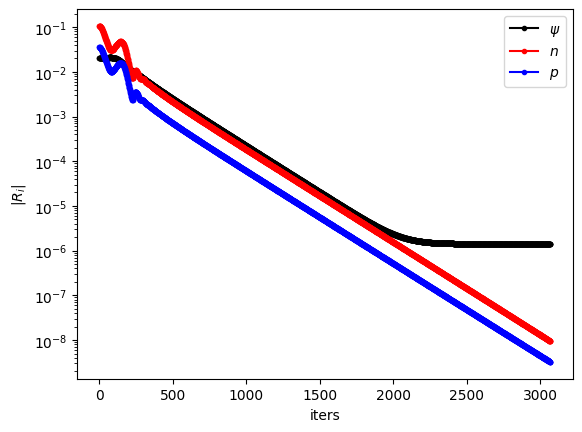

In [13]:
jac_time = time.time()
U_jac = solve_jacobi_3_eq(U,J, err_max=1e-8, relaxation=0.3,use_log_sol=False)
jac_time = time.time() - jac_time

## Solution Jacobi

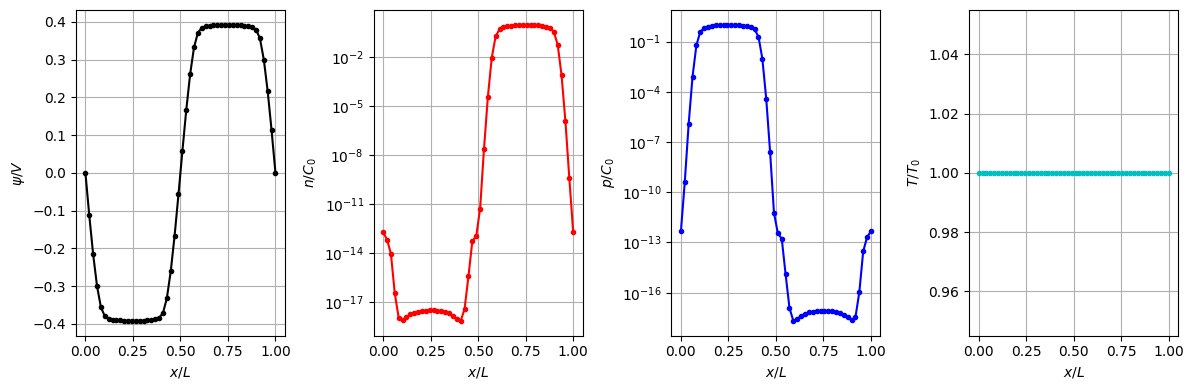

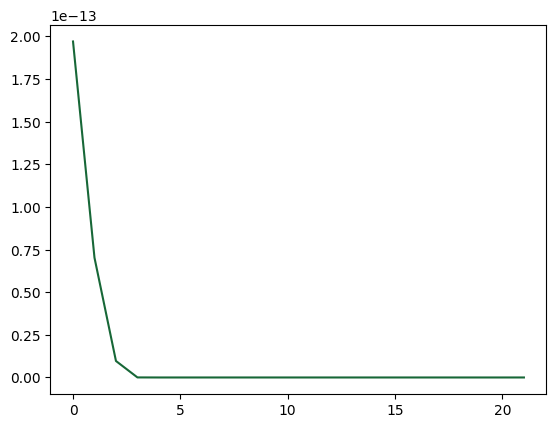

In [14]:
plot_solution(U_jac, T, is_log=False)
plt.plot(U_jac[N:int(1.45*N)])
plt.show()

## Jacobi solver

In [15]:
def solve_jacobi(A, B, X, relaxation = 0.3, verbose = False, max_iters = 1e4, err_max = 1e-5):
    N_max = max_iters

    # init jacobi
    err = 1e10
    k = 0

    err_hist = []

    D = diagonal(A)
    dX = np.zeros(X.shape)

    # jacobi iterations
    while err > err_max and k < N_max:
        rhs = B - np.dot(A, X)
        dX = relaxation * (rhs - np.dot(matrix_minus_diagonal(A),dX)) / D
        X = X + dX
        # dU[0] = 0

        # error history
        err = np.linalg.norm(dX)
        err_hist.append(err)
        if k % 100 == 0 and verbose:
            print(f"Jacobi iter {k} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, ")
        k += 1

    # print convergence history
    if verbose:
        plt.semilogy(err_hist, 'k.-')
        plt.show()
    return X, k

# One system with pseudo-time stepping
The above system doesn't converge out of the bat. Gauss and charge conservation equations need to be solved simultaneously. Here I try with a pseudo-time step approach

In [16]:
def exponential_smoothing(U, dU):
    alpha = 1
    small_vals = 1e-18
    U2 = U.copy() + dU

    sm_du = smoothing(dU, Nb = 3, alpha=0.5)

    # U2[0:N] = 0.5*np.linspace(0, 1, N)

    for i in range(2*N):
        if U2[N+i] < 0:
            vn = np.log(U[N+i])
            dvn = sm_du[N+i] / (U[N+i] + small_vals)
            # if dvn > np.log(1 + 0.1):
            #     dvn = np.log(1 + 0.1)
            # if dvn < np.log(1 - 0.1):
            #     dvn = np.log(1 - 0.1)
            if np.abs(dvn) > 0.01:
                dvn = 0.01 * np.sign(dvn)
            vfn = vn + alpha *dvn
            new_n = np.exp(vfn)
            # if new_n < small_vals:
            #     new_n = small_vals
            U2[N+i] = new_n
    
    
    # for i in range(2*N):
    #     vn = np.log(U[N+i])
    #     dvn = dU[N+i] / (U[N+i] + small_vals)
    #     if np.abs(dvn) > 0.1:
    #         dvn = 0.1 * np.sign(dvn)
    #     vfn = vn + dvn
    #     new_n = np.exp(vfn)
    #     U2[N+i] = new_n
    return U2

def get_max_forcing(U, T, is_log = False):
    phi = U[0:N]
    if is_log:
        n = np.exp(U[N:2*N])
        p = np.exp(U[2*N:3*N])
    else:
        n = U[N:2*N]
        p = U[2*N:3*N]
    
    max_force = 0
    for i in range(N):
        ip1, _ = plus_minus_indeces(i)
        
        F  = np.abs(-(phi[ip1] - phi[i]) / dx + vt0_bar * (T[ip1] - T[i]) / dx)
        if F > max_force:
            max_force = F
    return max_force

def smoothing(R, Nb = 3, alpha = 0.1):
    R_new = R.copy()
    for i in range(N):
        indices = i - Nb//2 + np.arange(Nb)
        indices = indices[(indices >= -1) & (indices <= N)]
        if indices[0] == -1:
            indices[0] = N-1
        if indices[-1] == N:
            indices[-1] = 0
        # print(i, indices)
        sum = np.sum(R[indices])
        R_new[i] = (1 - alpha) * R[i] + alpha * sum / len(indices)

        sum = np.sum(R[N + indices])
        R_new[N + i] = (1 - alpha) * R[N + i] + alpha * sum / len(indices)

        sum = np.sum(R[2*N + indices])
        R_new[2*N + i] = (1 - alpha) * R[2*N + i] + alpha * sum / len(indices)
    return R_new

def solve_pseudo_time(CFL_max = 10, err_max = 1e-9, Nmax = 5000, use_logs = False):

    def plot_hist():
        plt.semilogy(err_phi, 'k.-', label="$\psi$")
        plt.semilogy(err_n, 'r.-', label="$n$")
        plt.semilogy(err_p, 'b.-', label="$p$")
        plt.xlabel("iters")
        plt.ylabel("$|R_i|$")
        plt.legend()
        plt.show()
    
    # init vars
    U = np.zeros(3*N)
    U = init_solution(U, is_log=use_logs)
    T = np.ones(N)
    
    J = np.zeros([3*N,3*N])
    S = np.zeros(3*N)
    Js = np.zeros([3*N,3*N])
    
    dU = np.zeros(3*N)

    # Pseudo-time stepping vars
    # Nmax = 5000 # maximum pseudo-time iterations
    n = 0 # pseudo-time iteration
    total_jacobi_subiters = 0
    # err_max=1e-4

    err = 1e20
    CFL = 0.7 * 1e-1
    lambda_max = np.max([eps0*Er/dx, mu_n*T[0]*vt0_bar/dx, mu_n*Vmax/L])
    dt = CFL_max * dx / lambda_max # pseudo time step
    
    # error history
    err_phi = []
    err_n = []
    err_p = []

    # peseudo time mass matrix
    M = dx/dt*np.eye(3*N)
    rhs = np.zeros(3*N)
    P = np.eye(3*N)

    while n < Nmax and err > err_max:
        J = compute_jacobian(J, U, T, is_log=use_logs, modified_jac=False)
        Js = compute_source_jacobian(Js, U, is_log=use_logs, modified_jac=False)
        A = J - Js

        # update matrix m
        CFL_min = CFL_max * 1e-3
        n_ramp = 500
        CFL = CFL_min + (CFL_max - CFL_min)/n_ramp*n
        if n > n_ramp:
            CFL = CFL_max
        F = get_max_forcing(U, T, is_log=use_logs)
        x = F*dx/vt0_bar/T[0]

        CFL = CFL_max
        dt = CFL * dx
        rhs = smoothing(rhs, Nb = 3, alpha=0.5)
        for i in range(N):
            M[i,i] = dx/dt * 4*eps0*Er/dx
            M[N+i, N+i] = dx/dt* 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))
            M[2*N+i, 2*N+i] = dx/dt* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))
            

            if n > 100 and n % 50 == 0:
                # M[i,i] = dx * 4*eps0*Er/dx  /max(dt, dt / (np.abs(rhs[i]) + 0*1e-3))
                M[N+i, N+i] = dx * 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[N+i]) + 0*1e-3))
                M[2*N+i, 2*N+i] = dx* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[2*N+i]) + 0*1e-3))

        A = M + J - Js
        
        
        S = source_term(S, U, is_log=use_logs)
        # rhs = S - np.dot(J, U)
        rhs = S
        rhs = compute_jacobian_u(rhs, U, T, is_log=use_logs)
        
        dU, sub_iters = solve_jacobi(A, rhs, dU, relaxation = 0.4, verbose=False, max_iters=500, err_max = 1e-15)
        # dU, sub_iters = gmres(A, rhs, rtol=1e-15, maxiter=20)
        dU[0] = 0

        err = np.linalg.norm(rhs)
        if err > 1e5:
            print("This is very likely diverging!")
            plot_hist()
            return U
            
        # error history
        err_phi.append(np.mean(np.abs(rhs[2:N-2])))
        err_n.append(np.linalg.norm(rhs[N:2*N]))
        err_p.append(np.linalg.norm(rhs[2*N:3*N]))
        err = np.sqrt(err_phi[-1]*err_phi[-1] + err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        err = np.sqrt(err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        total_jacobi_subiters += sub_iters
        if n % 100 == 0:
            dphi = np.mean(np.abs(rhs[2:N-2]))
            dn = np.linalg.norm(rhs[N:2*N])
            dp = np.linalg.norm(rhs[2*N:3*N])
            print(f"Pseudo-time step {n} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, sub-iters {total_jacobi_subiters/100}")
            print(f"\tpsi --  Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn ----- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp ----- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
            total_jacobi_subiters = 0
            # plot_solution(U, T, is_log=use_logs)
        
        # U = U + dU
        U = exponential_smoothing(U, dU)
        for i in range(3):
            U[i*N + N-1] = U[i*N]
        n += 1
    # print convergence history
    plot_hist()
    return U

## Solve pseudo-time stepping

Pseudo-time step 0 == Norm error 1.121e-01 ---- Min 1.121e-01, Max 1.121e-01, sub-iters 2.79
	psi --  Min 2.744e-03, Max 2.744e-03
	n ----- Min 1.064e-01, Max 1.064e-01
	p ----- Min 3.546e-02, Max 3.546e-02
Pseudo-time step 100 == Norm error 2.314e-04 ---- Min 2.314e-04, Max 2.314e-04, sub-iters 212.12
	psi --  Min 6.625e-06, Max 6.625e-06
	n ----- Min 2.195e-04, Max 2.195e-04
	p ----- Min 7.322e-05, Max 7.322e-05
Pseudo-time step 200 == Norm error 3.735e-07 ---- Min 3.735e-07, Max 3.735e-07, sub-iters 178.64
	psi --  Min 1.111e-08, Max 1.111e-08
	n ----- Min 3.504e-07, Max 3.504e-07
	p ----- Min 1.295e-07, Max 1.295e-07


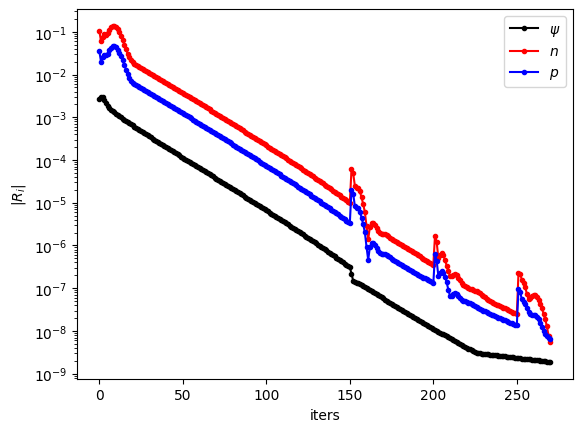

In [17]:
pt_time = time.time()
# U_pt = solve_pseudo_time(err_max=1e-10, CFL_max=10, Nmax=10000, use_logs=False)
U_pt = solve_pseudo_time(err_max=1e-8, CFL_max=10, Nmax=1500, use_logs=False)
pt_time = time.time() - pt_time

Jacobi time 23.28529381752014
Pseudo time step time 3.8895461559295654


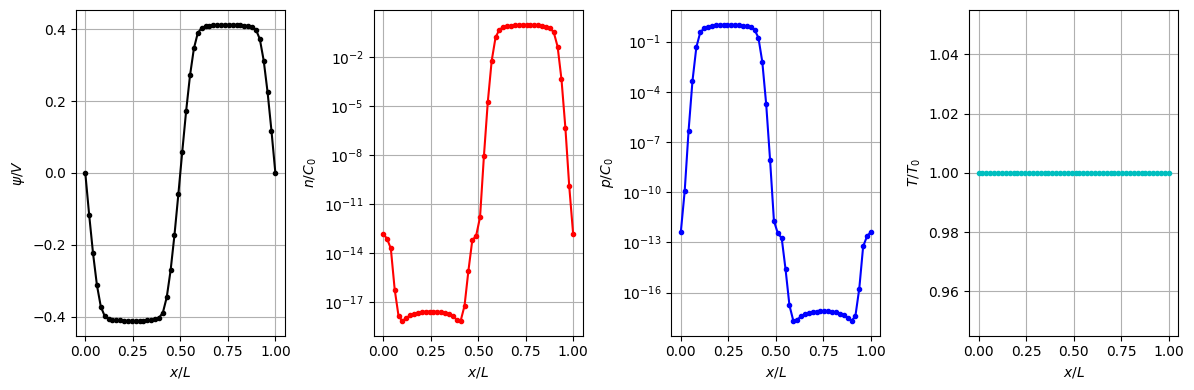

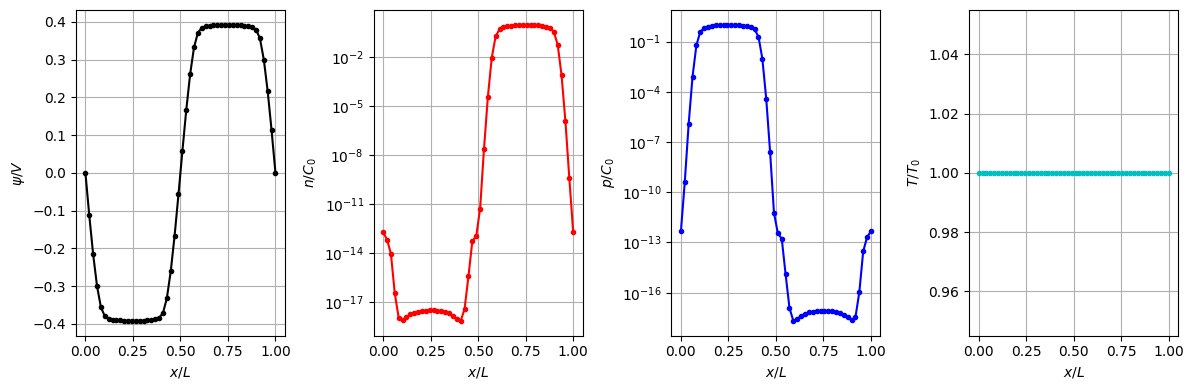

In [18]:
print(f"Jacobi time {jac_time}")
print(f"Pseudo time step time {pt_time}")
plot_solution(U_pt, T, is_log=False)
plot_solution(U_jac, T, is_log=False)

# Thermal solve

In [19]:
# thermal parameters
k0 = 1.56 * 1e-4 # W / (K um)
k = 1 # non-dimensional conductivity: k/k0

H0 = td.Q_e * mu0 * C0 * Vmax*Vmax / (L * L)

dT0 = H0 * L * L / k0

rho = 1000 * 1e-12 # kg/um^3
cp = 713 # J/(kg K)

print(H0)
print(t0)
print(T0/t0 /H0)
print(dT0)

0.009613059803999999
3.333333333333333e-12
9362263611691146.0
61.622178230769215


In [20]:
def compute_heat_source_term(U, T, i):
    ip1, im1 = plus_minus_indeces(i)
    
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]

    F_n = -(phi[ip1] - phi[im1]) / dx + vt0_bar * (T[ip1] - T[im1]) / (2 * dx)
    F_p = -(phi[ip1] - phi[im1]) / dx - vt0_bar * (T[ip1] - T[im1]) / (2 * dx)

    grad_n = (n[ip1] - n[im1]) / (2 * dx)
    grad_p = (p[ip1] - p[im1]) / (2 * dx)

    Jn = mu_n * n[i] * F_n + vt0_bar * mu_n * T[i] * grad_n
    Jp = mu_p * p[i] * F_p + vt0_bar * mu_p * T[i] * grad_p

    H = Jn*F_n + Jp*F_p

    R = (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))

    H += R * (Eg + 3*vt0_bar*T[i])

    return H * dx

def compute_heat_source(Sth, U, T):
    Sth.fill(0)
    for i in range(N):
        Sth[i] = compute_heat_source_term(U, T, i)
    return Sth

def compute_heat_source_jacobian(Jsth, U, T):
    Jsth.fill(0)
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    for i in range(N):
        # only considering the recombination generation
        R = (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))
        Jsth[i,i] = R * 3 * vt0_bar * dT0/T0 * dx
        
    return Jsth

def compute_thermal_jacobian(Jth, U, T):
    Jth.fill(0)
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)

        # -k grad(T)_1/2 + k grad(T)_-1/2
        Jth[i, im1] += -k / dx
        Jth[i, i] += 2 * k / dx
        Jth[i, ip1] += -k / dx
    
    return Jth

## Solve loosely coupled non-isothermal system

In [21]:
def update_T(T, dT):
    for i in range(N):
        new_T = T[i] + dT[i]
        if new_T <= 0:
            T[i] = 0.1 * T[i]
        else:
            T[i] = new_T

def solve_loosely_coupled(CFL_max = 10, err_max = 1e-9):
    def plot_hist():
        plt.semilogy(err_phi, 'k.-', label="$\psi$")
        plt.semilogy(err_n, 'r.-', label="$n$")
        plt.semilogy(err_p, 'b.-', label="$p$")
        plt.semilogy(err_T, 'c.-', label="$T$")
        plt.xlabel("iters")
        plt.ylabel("$|R_i|$")
        plt.legend()
        plt.show()
    
    # init vars
    U = np.zeros(3*N)
    U = init_solution(U)
    
    J = np.zeros([3*N,3*N])
    S = np.zeros(3*N)
    Js = np.zeros([3*N,3*N])

    T = np.ones(N)
    theta = np.zeros(N)
    rhs_th = np.zeros(N)
    rhs = np.zeros(3*N)
    Jth = np.zeros([N, N])
    Sth = np.zeros(N)
    Jsth = np.zeros([N, N])
    
    
    dU = np.zeros(3*N)
    dtheta = np.zeros(N)

    # Pseudo-time stepping vars
    Nmax = 4000 # maximum pseudo-time iterations
    n = 0 # pseudo-time iteration
    total_subiters = 0
    total_subiters_th = 0
    
    err = 1e20
    if np.isclose(vt0, Vmax):
        lambda_max = 4*dx/np.pi/np.pi/eps0 # estimated largest eigenvalue
    else:
        lambda_max = 1 / dx
    lambda_max = 1 / dx
    dt = CFL_max * dx / lambda_max # pseudo time step
    
    # error history
    err_phi = []
    err_n = []
    err_p = []
    err_T = []

    # peseudo time mass matrix
    M = np.eye(3*N)
    
    while n < Nmax and err > err_max:
        # update matrix m
        CFL_min = CFL_max * 1e-3
        n_ramp = 50
        CFL = CFL_min + (CFL_max - CFL_min)/n_ramp*n
        if n > n_ramp:
            CFL = CFL_max
        dt = CFL * dx
        F = get_max_forcing(U, T)
        x = F*dx/vt0_bar/T[0]
        rhs = smoothing(rhs, Nb = 3, alpha=0.5)
        for i in range(N):
            M[i,i] = dx/dt * 4*eps0*Er/dx
            M[N+i, N+i] = dx/dt* 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))
            M[2*N+i, 2*N+i] = dx/dt* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))

            if n> 50 and n % 50 == 0:
                # M[i,i] = dx * 4*eps0*Er/dx  /max(dt, dt / (np.abs(rhs[i]) + 0*1e-3))
                M[N+i, N+i] = dx * 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[N+i]) + 0*1e-3))
                M[2*N+i, 2*N+i] = dx* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[2*N+i]) + 0*1e-3))

        # solve fist Gauss + charge
        J = compute_jacobian(J, U, T)
        S = source_term(S, U)
        Js = compute_source_jacobian(Js, U)
        
        A = M + J - Js
        # rhs = S - np.dot(J, U)
        rhs = S
        rhs = compute_jacobian_u(rhs, U, T)
        
        dU, jac_iters = solve_jacobi(A, rhs, dU, relaxation = 0.5, verbose=False, max_iters=200, err_max =1e-15)
        # dU, jac_iters = gmres(A, rhs, rtol=1e-15, maxiter=100)
        dU[0] = 0
        # U = U + dU
        U = exponential_smoothing(U, dU)
        # periodicity
        for i in range(3):
            U[i*N + N-1] = U[i*N]

        # Now update temperature
        for kth in range(1):
            Mth = dx/dt * np.eye(N) * k / dx
            Jth = compute_thermal_jacobian(Jth, U, T)
            Sth = compute_heat_source(Sth, U, T)
            Jsth = compute_heat_source_jacobian(Jsth, U, T)

            if n> 50 and n % 10 == 0:
                M[i,i] = k /max(dt, dt / (np.abs(rhs_th[i])))

            # BCs
            for i in range(N):
                Jth[0, i] = 0
            Jth[0,0] = 1
            theta[0] = (300 - T0)/dT0          
    
            Ath = Mth + Jth - Jsth
            rhs_th = Sth - np.dot(Jth, theta)
            # BC
            rhs_th[0] = 0
            
            dtheta, jac_iters_th = solve_jacobi(Ath, rhs_th, dtheta, relaxation = 0.5, verbose=False, max_iters=200, err_max = 1e-10)
            # dtheta, jac_iters_th = gmres(Ath, rhs_th, rtol=1e-10, maxiter=50)
            theta += dtheta
            # theta[0] = 0
            T = np.ones(N)
            update_T(T, dT0 * theta / T0)
            # T = 1 + dT0 * theta / T0
            T[N-1] = T[0]
        

        err = np.linalg.norm(rhs[N:3*N])
        err_th = np.linalg.norm(rhs_th)
        err = np.sqrt(err*err + err_th*err_th)
        if err > 1e5:
            print("This is very likely diverging!")
            plot_hist()
            return U, T
            
        # error history
        err_phi.append(np.linalg.norm(rhs[2:N-2]))
        err_n.append(np.linalg.norm(rhs[N:2*N]))
        err_p.append(np.linalg.norm(rhs[2*N:3*N]))
        err_T.append(err_th)
        total_subiters += jac_iters
        total_subiters_th += jac_iters_th
        
        if n % 100 == 0:
            dphi = np.linalg.norm(rhs[2:N-2])
            dn = np.linalg.norm(rhs[N:2*N])
            dp = np.linalg.norm(rhs[2*N:3*N])
            print(f"Pseudo time step {n} == Norm error {err:0.3e} ---- jac iters {total_subiters/100} -- jac iters heat {total_subiters_th/100}")
            print(f"\tpsi {np.linalg.norm(dphi):0.3e} ---- Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn   {np.linalg.norm(dn):0.3e} ---- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp   {np.linalg.norm(dp):0.3e} ---- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
            print(f"\tT   {err_th:0.3e} ---- Min {np.min(np.abs(rhs_th)):0.3e}, Max {np.max(np.abs(rhs_th)):0.3e}")
            total_subiters = 0
            total_subiters_th = 0
        
        n += 1
    # print convergence history
    plot_hist()
    return U, T

Pseudo time step 0 == Norm error 1.121e-01 ---- jac iters 0.4 -- jac iters heat 0.02
	psi 2.019e-02 ---- Min 2.019e-02, Max 2.019e-02
	n   1.064e-01 ---- Min 1.064e-01, Max 1.064e-01
	p   3.546e-02 ---- Min 3.546e-02, Max 3.546e-02
	T   1.880e-06 ---- Min 0.000e+00, Max 6.128e-07
Pseudo time step 100 == Norm error 1.374e-03 ---- jac iters 108.57 -- jac iters heat 136.99
	psi 2.084e-04 ---- Min 2.084e-04, Max 2.084e-04
	n   9.772e-04 ---- Min 9.772e-04, Max 9.772e-04
	p   3.258e-04 ---- Min 3.258e-04, Max 3.258e-04
	T   9.088e-04 ---- Min 0.000e+00, Max 1.943e-04
Pseudo time step 200 == Norm error 2.778e-05 ---- jac iters 118.98 -- jac iters heat 128.08
	psi 8.763e-07 ---- Min 8.763e-07, Max 8.763e-07
	n   3.974e-06 ---- Min 3.974e-06, Max 3.974e-06
	p   1.386e-06 ---- Min 1.386e-06, Max 1.386e-06
	T   2.746e-05 ---- Min 0.000e+00, Max 5.491e-06
Pseudo time step 300 == Norm error 6.891e-07 ---- jac iters 117.85 -- jac iters heat 58.7
	psi 4.341e-08 ---- Min 4.341e-08, Max 4.341e-08
	n  

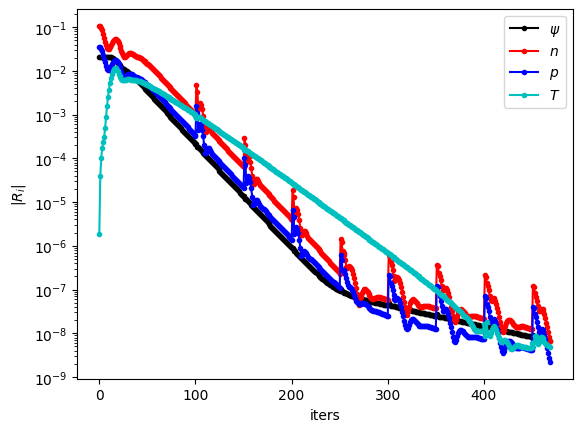

In [22]:
time_thermal_pt = time.time()
U, T = solve_loosely_coupled(CFL_max = 10, err_max = 1e-8)
time_thermal_pt = time.time() - time_thermal_pt

Time loosely coupled thermal (pseudo-time stepping: 6.552103281021118 s


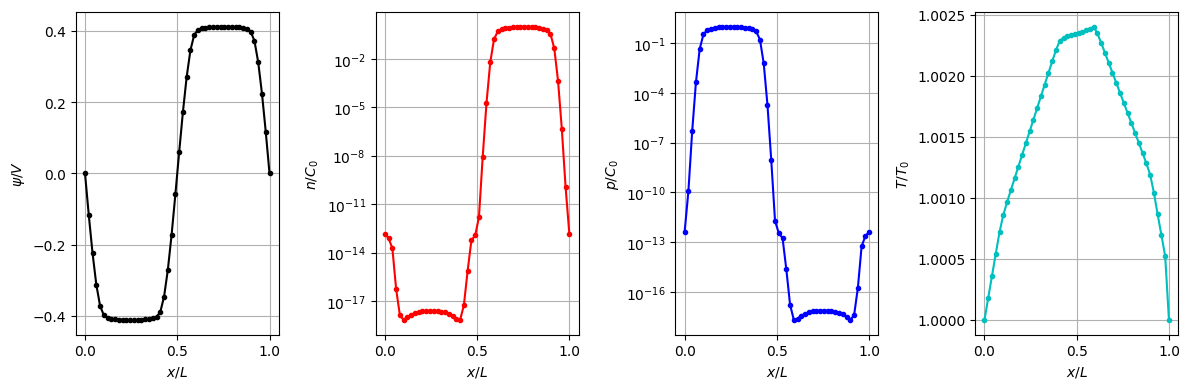

In [23]:
print(f"Time loosely coupled thermal (pseudo-time stepping: {time_thermal_pt} s")
plot_solution(U, T)

# Eigenvalues

In [33]:
def analytical_numerical_eigenvalues(N, forcing):
    """Returns the numerical eigenvalues obtained from the analytical expression"""
    ks = np.linspace(0, N-1, N)
    omega = 2*np.pi/N*1j
    x = forcing*dx/vt0_bar/T[0]

    # analytical (numerical) eigenvalues - electrons
    lambdas_n = -(B(-x) + B(x)) + B(x)*np.exp(-ks*omega) +B(-x)*np.exp(-(N-1)*ks*omega)
    lambdas_n = lambdas_n * mu_n*vt0_bar*T[0]/dx

    # analytical (numerical) eigenvalues - holes
    lambdas_p = -(B(-x) + B(x)) + B(-x)*np.exp(-ks*omega) +B(x)*np.exp(-(N-1)*ks*omega)
    lambdas_p = lambdas_p * mu_p*vt0_bar*T[0]/dx

    # analytical (numerical) eigenvalues - psi
    lambdas_psi = -2 + np.exp(-ks*omega) + np.exp(-(N-1)*ks*omega)
    lambdas_psi = eps0*Er/dx * lambdas_psi

    return lambdas_psi, lambdas_n, lambdas_p

def compute_eigenvalues(U, T, is_log = False, plot = False, forcing = False):
    # Compute eigenvalues and eigenvectors
    J = np.zeros([3*N,3*N])
    J = compute_jacobian(J, U, T, is_log=is_log, forcing = forcing)

    # Js = np.zeros([3*N,3*N])
    # Js = compute_source_jacobian(Js, U)
    # J = J - Js

    # get only the diffusion part
    # J = J[N:3*N, N:3*N]

    # Jad = compute_jacobian_ad(Jad, U, T)
    eigenvalues, eigenvectors = np.linalg.eig(J)

    # print("Egenvalues:")
    # print(f"Real Min {np.min(np.real(eigenvalues))},Real max {np.max(np.real(eigenvalues))}, Imag Min {np.min(np.imag(eigenvalues))}, Imag max {np.max(np.imag(eigenvalues))}")
    if plot:
        plt.plot(-np.real(eigenvalues), np.imag(eigenvalues), '.')
        if forcing or np.isclose(forcing, 0.0):
            lambdas_psi, lambdas_n, lambdas_p = analytical_numerical_eigenvalues(N, forcing)
            plt.plot(np.real(lambdas_psi), np.imag(lambdas_psi), 'r-')
            plt.plot(np.real(lambdas_n), np.imag(lambdas_n), 'k-')
            plt.plot(np.real(lambdas_p), np.imag(lambdas_p), 'b-')

        plt.xlabel("Real($\lambda$)")
        plt.ylabel("Imag($\lambda$)")
        # plt.xlim(-300, 0.1)
        plt.show()
    return eigenvalues


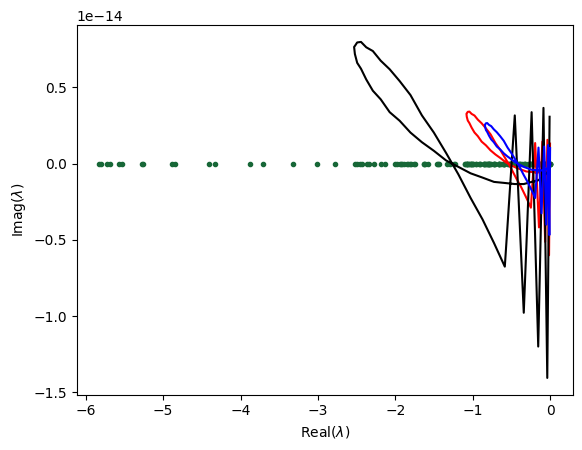

In [34]:
# eigenvalues for computed solution
_ = compute_eigenvalues(U_pt, T, is_log = False, plot = True)

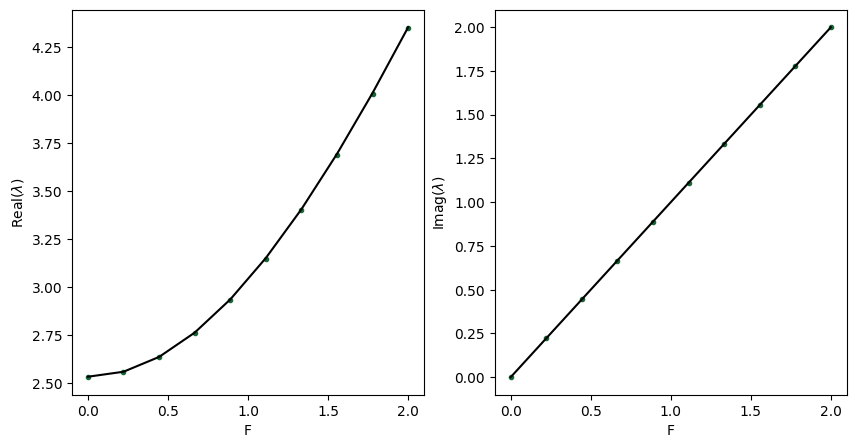

In [36]:
# For a given frequency compute sweep with forcing

omega = 2*np.pi
N = 50# NUmber of "grid" nodes
dx = L / (N - 1) / L # dimensionless grid spacing
max_r = []
max_i = []
forcing = np.linspace(0, 2, 10)
for F in forcing:
    # generate solutions
    U = np.zeros(3*N)
    U[0:N] = np.linspace(0, F, N)
    U[N:2*N] = np.sin(omega*np.linspace(0, 1, N))
    U[2*N:3*N] = -np.sin(omega*np.linspace(0, 1, N))
    T = np.ones(N)
    eig = compute_eigenvalues(U, T, is_log = False, plot = False, forcing = F)  
    max_r.append(np.max(np.real(eig)))
    max_i.append(np.max(np.imag(eig)))


x = forcing*dx/vt0_bar/T[0]
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(forcing, max_r, '.')
ax[0].plot(forcing, 2*mu_n*vt0_bar*T[0]/dx*np.array([B(xx)+B(-xx) for xx in x]), 'k-')
ax[0].set_xlabel("F")
ax[0].set_ylabel("Real($\lambda$)")
ax[1].plot(forcing, max_i, '.')
ax[1].plot(forcing, -mu_n*vt0_bar*T[0]/dx*np.array([B(xx)-B(-xx) for xx in x]), 'k-')
ax[1].set_xlabel("F")
ax[1].set_ylabel("Imag($\lambda$)")
plt.show()


## Comparison against exact eigenvalues

Text(0, 0.5, 'Imag($\\lambda$)')

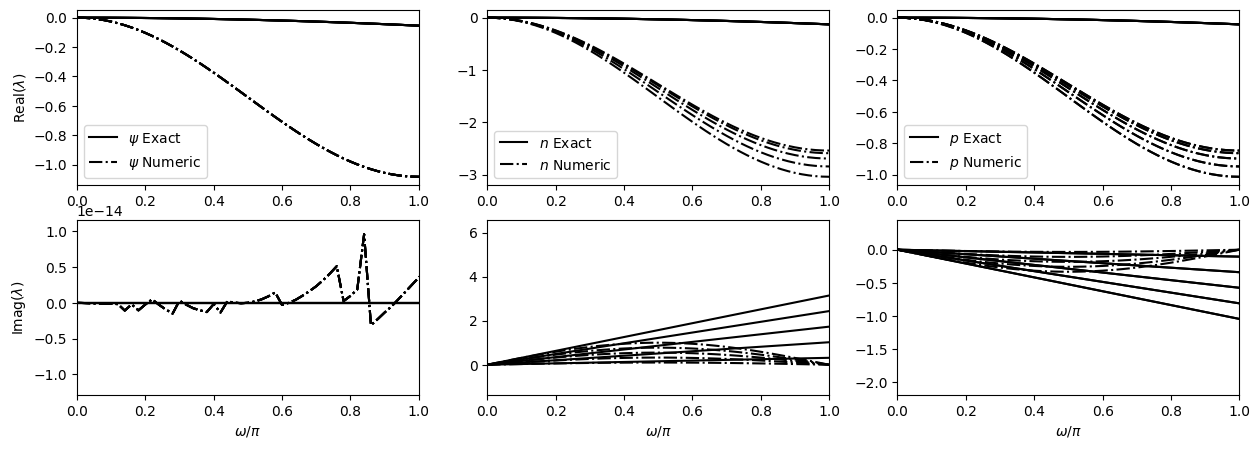

In [59]:
N = 100
ks = np.linspace(0, N-1, N)
omega = 2*np.pi/N

_, ax = plt.subplots(2, 3, figsize=(15, 5))
for n, F in enumerate(np.linspace(1e-1, 1, 5)):
    lambdas_psi, lambdas_n, lambdas_p = analytical_numerical_eigenvalues(N, F)

    # get exact eigenvalues
    l_exact_psi = -eps0*Er*omega*omega*ks*ks
    l_exact_n = mu_n*(1j*omega*ks*F - omega*omega*ks*ks*vt0_bar*T[0])
    l_exact_p = mu_p*(-1j*omega*ks*F - omega*omega*ks*ks*vt0_bar*T[0])

    if n == 0:
        ax[0][0].plot(ks*omega/np.pi, np.real(l_exact_psi), 'k-', label="$\psi$ Exact")
        ax[0][0].plot(ks*omega/np.pi, np.real(lambdas_psi), 'k-.', label="$\psi$ Numeric")
    else:
        ax[0][0].plot(ks*omega/np.pi, np.real(l_exact_psi), 'k-')
        ax[0][0].plot(ks*omega/np.pi, np.real(lambdas_psi), 'k-.')
    ax[1][0].plot(ks*omega/np.pi, np.imag(l_exact_psi), 'k-')
    ax[1][0].plot(ks*omega/np.pi, np.imag(lambdas_psi), 'k-.')

    if n == 0:
        ax[0][1].plot(ks*omega/np.pi, np.real(l_exact_n), 'k-', label="$n$ Exact")
        ax[0][1].plot(ks*omega/np.pi, np.real(lambdas_n), 'k-.', label="$n$ Numeric")
    else:
        ax[0][1].plot(ks*omega/np.pi, np.real(l_exact_n), 'k-')
        ax[0][1].plot(ks*omega/np.pi, np.real(lambdas_n), 'k-.')
    ax[1][1].plot(ks*omega/np.pi, np.imag(l_exact_n), 'k-')
    ax[1][1].plot(ks*omega/np.pi, np.imag(lambdas_n), 'k-.')

    if n == 0:
        ax[0][2].plot(ks*omega/np.pi, np.real(l_exact_p), 'k-', label="$p$ Exact")
        ax[0][2].plot(ks*omega/np.pi, np.real(lambdas_p), 'k-.', label="$p$ Numeric")
    else:
        ax[0][2].plot(ks*omega/np.pi, np.real(l_exact_p), 'k-')
        ax[0][2].plot(ks*omega/np.pi, np.real(lambdas_p), 'k-.')
    ax[1][2].plot(ks*omega/np.pi, np.imag(l_exact_p), 'k-')
    ax[0][2].plot(ks*omega/np.pi, np.real(lambdas_p), 'k-.')
    ax[1][2].plot(ks*omega/np.pi, np.imag(l_exact_p), 'k-')
    ax[1][2].plot(ks*omega/np.pi, np.imag(lambdas_p), 'k-.')

for i in range(3):
    ax[1][i].set_xlabel("$\omega / \pi$")
    ax[0][i].set_xlim(0, 1)
    ax[1][i].set_xlim(0, 1)
    ax[0][i].legend()
ax[0][0].set_ylabel("Real($\lambda$)")
ax[1][0].set_ylabel("Imag($\lambda$)")
    

# Convergence order
In order to get the convergence order I'm going to decouple Gauss' equation from carriers. This simplification does not affect the numerical scheme so we can check convergence with the analytical solution. 
I will simplify further by assuming no generation/recombination.

In [27]:
# rewriting here the source terms to avoid
def source_term_simplified(S):
    S.fill(0)
    
    for i in range(N):
        S[i] = dx * (- np.sin(2*np.pi*dx*i))
    # plt.plot(S[0:N], 'k.-')
    # plt.grid(True)
    # plt.show()
    return S

def compute_jacobian_simplified(J, U):
    # reset jacobian 
    J.fill(0)

    phi = U[0:N]
    
    # fill in Gauss equation terms
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        J[i,im1] = - eps0 * Er / dx
        J[i,i] = 2 * eps0 * Er / dx
        J[i,ip1] = - eps0 * Er / dx
    
    # fill in conservation eqs.
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        F_n1_2 = -(phi[i] - phi[im1]) / dx
        F_1_2  = -(phi[ip1] - phi[i]) / dx

        Fp_n1_2 = -(phi[i] - phi[im1]) / dx
        Fp_1_2  = -(phi[ip1] - phi[i]) / dx
        
        T_n1_2 = 1
        T_1_2 = 1
        
        # n terms
        J[N+i, N+im1] += -mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar)
        J[N+i, N+i] += mu_n * vt0_bar /dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar)) 
        J[N+i, N+ip1] += -mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar)

        # p terms
        J[2*N+i, 2*N+im1] += - mu_p * vt0_bar * T_n1_2/dx * B(-Fp_n1_2 * dx / T_n1_2 / vt0_bar)
        J[2*N+i, 2*N+i] += mu_p * vt0_bar /dx * (T_1_2 * B(-Fp_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(Fp_n1_2 * dx / T_n1_2 / vt0_bar))
        J[2*N+i, 2*N+ip1] += - mu_p * vt0_bar * T_1_2/dx * B(Fp_1_2 * dx / T_1_2 / vt0_bar)
    return J

In [28]:
# solver
def solve_pseudo_time_simplified(CFL_max = 10, err_max = 1e-9, Nmax = 5000, use_logs = False):

    def plot_hist():
        plt.semilogy(err_phi, 'k.-', label="$\psi$")
        plt.semilogy(err_n, 'r.-', label="$n$")
        plt.semilogy(err_p, 'b.-', label="$p$")
        plt.xlabel("iters")
        plt.ylabel("$|R_i|$")
        plt.legend()
        plt.show()
    
    # init vars
    U = np.ones(3*N)
    for i in range(N):
        U[i] = 1
        U[N+i] = 1 + np.sin(2*np.pi*dx*i)
        U[2*N+i] = 1 - np.sin(2*np.pi*dx*i)
    T = np.ones(N)
    
    J = np.zeros([3*N,3*N])
    S = np.zeros(3*N)
    
    dU = np.zeros(3*N)

    n = 0 # pseudo-time iteration
    total_jacobi_subiters = 0

    err = 1e20
    
    # error history
    err_phi = []
    err_n = []
    err_p = []

    # peseudo time mass matrix
    M = np.eye(3*N)
    rhs = np.zeros(3*N)

    while n < Nmax and err > err_max:
        J = compute_jacobian_simplified(J, U)
        A = J

        # update matrix m
        # CFL_min = CFL_max * 1e-3
        # n_ramp = 500
        # CFL = CFL_min + (CFL_max - CFL_min)/n_ramp*n
        # if n > n_ramp:
        #     CFL = CFL_max
        # F = get_max_forcing(U, T, is_log=use_logs)
        # x = F*dx/vt0_bar/T[0]

        # CFL = CFL_max
        # dt = CFL * dx
        # rhs = smoothing(rhs, Nb = 3, alpha=0.5)
        # for i in range(N):
        #     M[i,i] = dx/dt * 4*eps0*Er/dx
        #     M[N+i, N+i] = dx/dt* 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))
        #     M[2*N+i, 2*N+i] = dx/dt* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x))

        #     if n> 100 and n % 50 == 0:
        #         # M[i,i] = dx * 4*eps0*Er/dx  /max(dt, dt / (np.abs(rhs[i]) + 0*1e-3))
        #         M[N+i, N+i] = dx * 2*mu_n*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[N+i]) + 0*1e-3))
        #         M[2*N+i, 2*N+i] = dx* 2*mu_p*vt0_bar*T[0]/dx*np.abs(B(x)+B(-x)) /max(dt, dt / (np.abs(rhs[2*N+i]) + 0*1e-3))

        # A = M + J
        
        
        S = source_term_simplified(S)
        rhs = S - np.dot(J, U)
        
        # dU, sub_iters = solve_jacobi(A, rhs, dU, relaxation = 0.35, verbose=False, max_iters=100, err_max = err_max / 10)
        dU, sub_iters = gmres(A, rhs, rtol=1e-15, maxiter=200)
        for i in range(3):
            dU[i*N] = 0

        err = np.linalg.norm(rhs)
        if err > 1e5:
            print("This is very likely diverging!")
            plot_hist()
            return U
            
        # error history
        err_phi.append(np.mean(np.abs(rhs[2:N-2])))
        err_n.append(np.linalg.norm(rhs[N:2*N]))
        err_p.append(np.linalg.norm(rhs[2*N:3*N]))
        err = np.sqrt(err_phi[-1]*err_phi[-1] + err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        err = np.sqrt(err_n[-1]*err_n[-1] + err_p[-1]*err_p[-1])
        total_jacobi_subiters += sub_iters
        if n % 100 == 0:
            dphi = np.mean(np.abs(rhs[2:N-2]))
            dn = np.linalg.norm(rhs[N:2*N])
            dp = np.linalg.norm(rhs[2*N:3*N])
            print(f"Pseudo-time step {n} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, last sub iters {total_jacobi_subiters/100}")
            print(f"\tpsi --  Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn ----- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp ----- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
            total_jacobi_subiters = 0
            # plot_solution(U, T, is_log=use_logs)
        
        # U = U + dU
        U = exponential_smoothing(U, dU)
        for i in range(3):
            U[i*N + N-1] = U[i*N]
            
        n += 1
    # print convergence history
    plot_hist()
    return U

## Exact solution

In [29]:
def exact_sol():
    U = np.zeros(3*N)
    omega = 2*np.pi
    for i in range(N):
        U[i] = 1 -np.sin(omega*dx*i) / eps0/Er/omega/omega
        U[N+i] = np.exp(-np.sin(omega*dx*i) / eps0/Er/omega/omega/vt0_bar/1)
        U[2*N+i] = np.exp(np.sin(omega*dx*i) / eps0/Er/omega/omega/vt0_bar/1)
    return U

def plot_solution_with_exact(U, plot = True):
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]

    U_exact = exact_sol()
    phi_exact = U_exact[0:N]
    n_exact = U_exact[N:2*N]
    p_exact = U_exact[2*N:3*N]

    if plot:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].plot(np.linspace(0,1,N), phi, 'k.-')
        ax[0].plot(np.linspace(0,1,N), phi_exact, 'k-')
        ax[0].set_ylabel("$\psi/V$")
        
        ax[1].plot(np.linspace(0,1,N), n, 'r.-')
        ax[1].plot(np.linspace(0,1,N), n_exact, 'r-')
        ax[1].set_ylabel("$n/C_0$")
        
        ax[2].plot(np.linspace(0,1,N), p, 'b.-')
        ax[2].plot(np.linspace(0,1,N), p_exact, 'b-')
        ax[2].set_ylabel("$p/C_0$")

        for i in range(3):
            ax[i].set_xlabel("$x/L$")
            ax[i].grid(True)
        
        plt.tight_layout()
        plt.show()

    # compute error. Integral over the domain normalized by the domain length
    phi_err = np.sum(np.abs(phi - phi_exact))/N
    n_err = np.sum(np.abs(n - n_exact))/N
    p_err = np.sum(np.abs(p - p_exact))/N
    return phi_err, n_err, p_err
    

## Loop

In [30]:
eps0 = 1/Er/(2*np.pi)**2
vt0_bar = 1

errs_phi = []
errs_n = []
errs_p = []

nodes = [10, 20, 50, 100]
# nodes = [11, 21]

for N in nodes:
    dx = L / (N - 1) / L
    U = solve_pseudo_time_simplified(CFL_max = 100, err_max = 1e-10, Nmax = 5000)
    err_phi, err_n, err_p = plot_solution_with_exact(U, plot = True)
    errs_phi.append(err_phi)
    errs_n.append(err_n)
    errs_p.append(err_p)
    print(f"N = {N} == phi err {err_phi:0.3e}, n err {err_n:0.3e}, p err {err_p:0.3e}")

Pseudo-time step 0 == Norm error 9.417e+00 ---- Min 9.417e+00, Max 9.417e+00, last sub iters 0.0
	psi --  Min 8.122e-02, Max 8.122e-02
	n ----- Min 8.933e+00, Max 8.933e+00
	p ----- Min 2.978e+00, Max 2.978e+00
Pseudo-time step 100 == Norm error 1.039e-03 ---- Min 1.039e-03, Max 1.039e-03, last sub iters 168.0
	psi --  Min 1.503e-17, Max 1.503e-17
	n ----- Min 9.857e-04, Max 9.857e-04
	p ----- Min 3.286e-04, Max 3.286e-04
Pseudo-time step 200 == Norm error 1.128e+00 ---- Min 1.128e+00, Max 1.128e+00, last sub iters 144.0
	psi --  Min 2.891e-17, Max 2.891e-17
	n ----- Min 1.128e+00, Max 1.128e+00
	p ----- Min 1.635e-02, Max 1.635e-02


KeyboardInterrupt: 

## Plot errors

In [ ]:
plt.loglog(nodes, np.array(errs_phi)*1e2, 'k.-', label="$\psi$")
plt.semilogy(nodes, errs_n, 'r.-', label="$n$")
plt.semilogy(nodes, errs_p, 'b.-', label="$p$")
plt.semilogy(nodes, 170/np.array(nodes)**2, 'k--', label="$O(N^{-2})$")
plt.semilogy(nodes, 2/np.array(nodes)**2, 'k--')
plt.xlabel("N")
plt.ylabel("$\sum(|\Delta U|)/N$")
plt.legend()
plt.show()